# Training of the *Acceptance model*

In this notebook we setup the training for the acceptance model, based on a Deep Neural Network.

This notebook is part of a pipeline and requires the data preprocessed with the notebook [Preprocessing.ipynb](./Preprocessing.ipynb).

## Enviornment setup and libraries

In this notebooks we will use the standard software stack for TensorFlow machine learning applications.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

To ensure a GPU is found and properly loaded in the notebook kernel to the benefit of TensorFlow, the output of the following block should be similar to `'/device:GPU:0'`.
If a GPU is not found, the string will be empty.

In [2]:
tf.test.gpu_device_name()

''

## Load datasets

Preprocessed datasets were stored in *Apache feather* format and can be reloaded with our custom `FeatherReader` designed to stream the datasets into TensorFlow or Dask format.

We are loading in particular:
 * the **training** dataset to train the network
 * the **validation** dataset to evaluate the network performance at each epoch and identify overtraining effects

In [3]:
from feather_io import FeatherReader    

reader_train = FeatherReader(environ.get("TRAIN_DATA", "acceptance-train"), max_files=3)
ds_train = reader_train.as_tf_dataset()

reader_val = FeatherReader(environ.get("VAL_DATA", "acceptance-validation"), max_files=1)
ds_val = reader_val.as_tf_dataset()

We load a small batch of data to identify the number of conditional and target features and automate the definition of the neural network architecture.

In [4]:
X, y = next(iter(ds_train.batch(1_000_000)))
X.shape, y.shape

(TensorShape([1000000, 12]), TensorShape([1000000, 1]))

## Model definition

The function we are modelling is not a trivial one, requiring a sufficiently deep neural network.
In order to limit the effect of the vanishing gradient and make the trainig procedure faster, we are using the concept of Residual Layer, introducing skipping connections between the input and the output of each layer.

With residual layers, the neural network is trained to learn the deviation from identity which is a much less demanding task than learning the whole transformation.

The output layer of the neural network has a sigmoid activation function to be mapped into the interval 0-1 and being interpreted as the **probability for the particle of being in acceptance**.



In [5]:
from pidgan.players.classifiers import ResClassifier

model = ResClassifier(
    num_hidden_layers=10,
    mlp_hidden_units=128,
    mlp_hidden_activation="relu",
    mlp_hidden_kernel_regularizer=tf.keras.regularizers.L2(5e-4),
    mlp_dropout_rates=0.0,
    name="classifier",
)

In [6]:
model(X[:256])
model.summary()

Model: "classifier_func"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 128)                  1664      ['input_1[0][0]']             
                                                                                                  
 dropout_0 (Dropout)         (None, 128)                  0         ['dense_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dropout_0[0][0]']           
                                                                                    

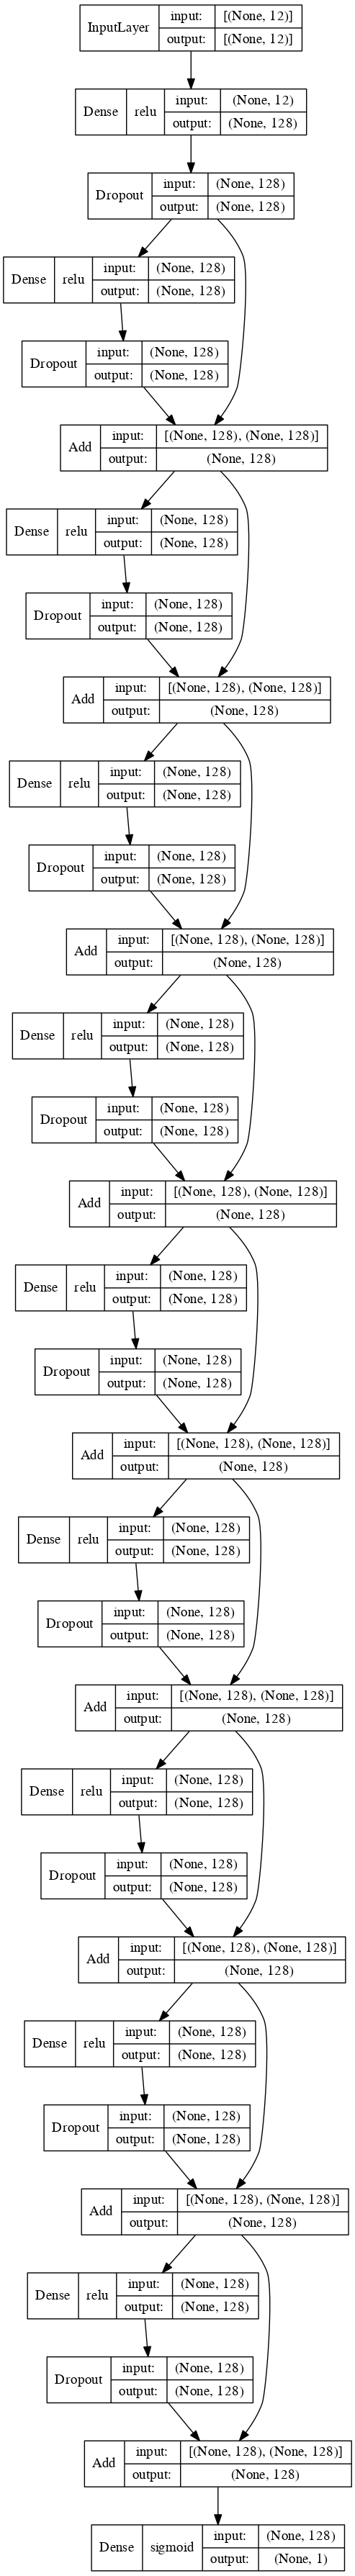

In [7]:
tf.keras.utils.plot_model(
    model.export_model,
    to_file="./images/acceptance-model.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

The rest of the training procedure is rather standard:
 * loss function: [binary cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
 * optimizer: [RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop) or [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [8]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

To speed up convergence, we split the training procedure in two steps. 
First, we proceed at high learning rate and then we operate some fine tuning of the network drastrically reducing it.
Similar results might be obtained in a more elegant way using a keras [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/).

Instead of setting a fixed number of epochs, we switch from one learning rate to the next one upon lack of improvement for at least 5 epochs.

In [9]:
model.compile(
    loss=BinaryCrossentropy(label_smoothing=0.05),
    metrics=tf.keras.metrics.AUC(name="auc"),
    optimizer=Adam(1e-2),
)

In [10]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

lr_sched = LearnRateExpDecay(
    model.optimizer,
    decay_rate=0.1,
    decay_steps=20_000,
    verbose=True,
)

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_auc",
#     min_delta=1e-5,
#     patience=3,
#     mode="max",
# )

In [11]:
batch_size = 25_000
num_epochs = 200

data_train = ds_train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data_val = next(iter(ds_val.batch(batch_size)))

callbacks = [lr_sched]  # [lr_sched, early_stop]

train = model.fit(data_train, epochs=num_epochs, validation_data=data_val, callbacks=callbacks)

Epoch 1/200
196/196 [==============================] - 28s 126ms/step - loss: 1.2071 - auc: 0.9364 - lr: 0.0099 - val_loss: 0.6483 - val_auc: 0.9803
Epoch 2/200
196/196 [==============================] - 25s 122ms/step - loss: 0.5584 - auc: 0.9815 - lr: 0.0097 - val_loss: 0.4847 - val_auc: 0.9835
Epoch 3/200
196/196 [==============================] - 25s 122ms/step - loss: 0.4364 - auc: 0.9837 - lr: 0.0095 - val_loss: 0.3932 - val_auc: 0.9852
Epoch 4/200
196/196 [==============================] - 26s 128ms/step - loss: 0.3674 - auc: 0.9847 - lr: 0.0092 - val_loss: 0.3416 - val_auc: 0.9860
Epoch 5/200
196/196 [==============================] - 26s 127ms/step - loss: 0.3237 - auc: 0.9855 - lr: 0.0090 - val_loss: 0.3051 - val_auc: 0.9868
Epoch 6/200
196/196 [==============================] - 26s 127ms/step - loss: 0.2946 - auc: 0.9863 - lr: 0.0088 - val_loss: 0.2827 - val_auc: 0.9873
Epoch 7/200
196/196 [==============================] - 25s 121ms/step - loss: 0.2750 - auc: 0.9868 - lr: 0

In [12]:
model.compile(
    loss=BinaryCrossentropy(label_smoothing=0.0),
    metrics=tf.keras.metrics.AUC(name="auc"),
    optimizer=Adam(1e-4),
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=5)

callbacks = None  # [early_stop]

train_ft = model.fit(data_train, epochs=int(num_epochs/2.0), validation_data=data_val, callbacks=callbacks)

Epoch 1/100
196/196 [==============================] - 27s 123ms/step - loss: 0.1146 - auc: 0.9916 - val_loss: 0.1101 - val_auc: 0.9921
Epoch 2/100
 34/196 [====>.........................] - ETA: 17s - loss: 0.1123 - auc: 0.9917

196/196 [==============================] - 24s 119ms/step - loss: 0.1114 - auc: 0.9918 - val_loss: 0.1091 - val_auc: 0.9922
Epoch 3/100
196/196 [==============================] - 24s 120ms/step - loss: 0.1107 - auc: 0.9919 - val_loss: 0.1086 - val_auc: 0.9924
Epoch 4/100
196/196 [==============================] - 24s 119ms/step - loss: 0.1103 - auc: 0.9920 - val_loss: 0.1083 - val_auc: 0.9924
Epoch 5/100
196/196 [==============================] - 25s 121ms/step - loss: 0.1101 - auc: 0.9920 - val_loss: 0.1081 - val_auc: 0.9924
Epoch 6/100
196/196 [==============================] - 24s 119ms/step - loss: 0.1100 - auc: 0.9920 - val_loss: 0.1080 - val_auc: 0.9924
Epoch 7/100
196/196 [==============================] - 24s 119ms/step - loss: 0.1099 - auc: 0.9920 - val_loss: 0.1079 - val_auc: 0.9925
Epoch 8/100
196/196 [==============================] - 24s 119ms/step - loss: 0.1098 - auc: 0.9920 - val_loss: 0.1078 - val_auc: 0.9925
Epoch 9/100
196/196 [==============================] - 24s 1

The two regimes are well visibile in the plot below, combining the two training phases in a single epoch count.

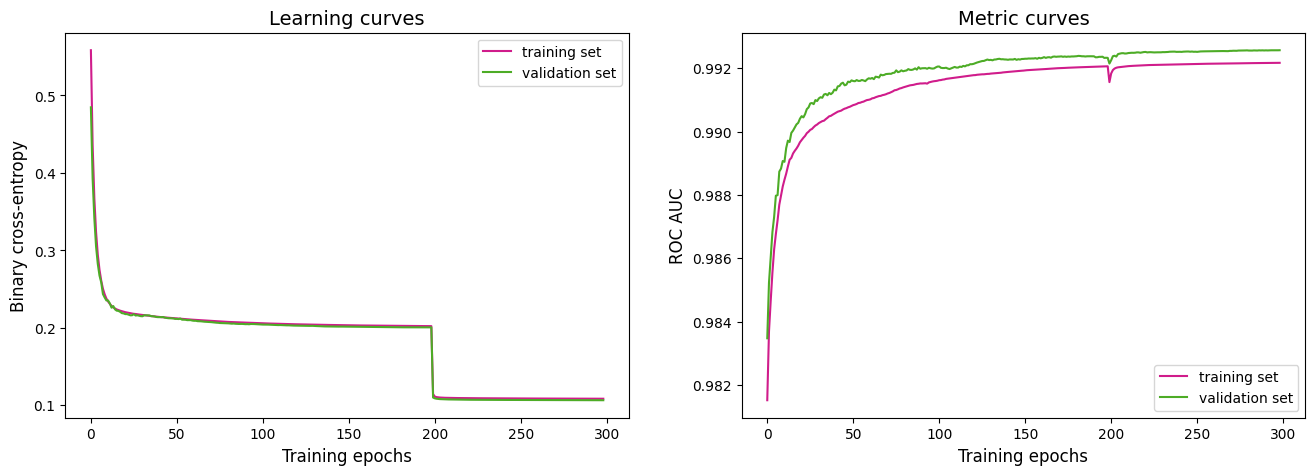

In [13]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Binary cross-entropy", fontsize=12)
plt.plot(train.history["loss"][1:] + train_ft.history["loss"], lw=1.5, color="#d01c8b", label="training set")
plt.plot(train.history["val_loss"][1:] + train_ft.history["val_loss"], lw=1.5, color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)
plt.plot(train.history["auc"][1:] + train_ft.history["auc"], lw=1.5, color="#d01c8b", label="training set")
plt.plot(train.history["val_auc"][1:] + train_ft.history["val_auc"], lw=1.5, color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

In [14]:
train_history = train.history.copy()
pd.DataFrame(train_history).to_csv("./exports/acceptance-train.csv")

train_history_ft = train_ft.history.copy()
train_history_ft.update({"lr": [1e-4 for _ in range(int(num_epochs/2.0))]})
pd.DataFrame(train_history_ft).to_csv("./exports/acceptance-train-ft.csv")

## A first, rough validation

While a proper validation of the model is demanded to a dedicated notebook, here we check that the training was not completely failed and provides reasonable numbers.

In particular, we compare the distributions of the training lables and of the predictions.

Clearly, the training labels are either 1 or 0 because a particle is either in acceptance or not. Instead, the output of the neural network is a probability and hence it will be distributed between 0 and 1. 

The comparison is used to ensure that both the training labels and the network output are not unreasonable, for example collapsed into a single value or with training labels belonging to a single category.

In [15]:
reader_test = FeatherReader(environ.get("TRAIN_DATA", "acceptance-test"), max_files=20)
ds_test = reader_test.as_tf_dataset()

400/400 [==============================] - 16s 38ms/step


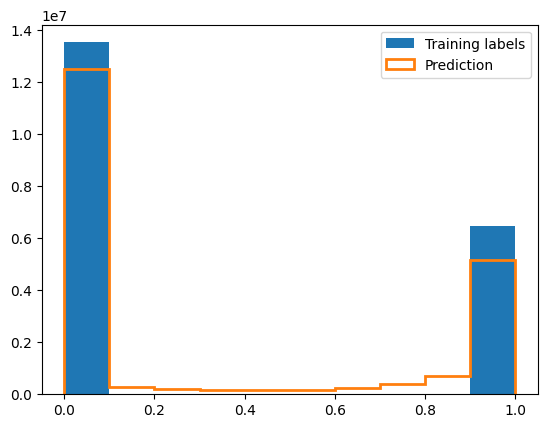

In [16]:
X_test, y_test = next(iter(ds_test.batch(20_000_000).as_numpy_iterator()))
preds = model.predict(X_test, batch_size=50_000)
bins = np.linspace(0, 1, 11)
plt.hist(y_test, bins=bins, label="Training labels")
plt.hist(preds, bins=bins, histtype='step', linewidth=2, label="Prediction")
plt.legend()
plt.show()

Then we can compare the distribution of a preprocessed variable before and after the application of the acceptance requirement.

Here, for example, we consider the preprocessed log-value of the momentum.

Since the variable is preprocessed, without applying any cut (**Generated**) we have a perfectly normalized Gaussian.

Applying the criterion `acceptance == 1` we get another distribution that we expect to model with decent approximation by applying the response of the trained neural networks as weights to the **Generated** dataset.

The comparison of the two histograms (obtained by applying a cut on the true acceptance or applying a weight on the acceptance probability) provides a first validation on the quality of the parametrization.

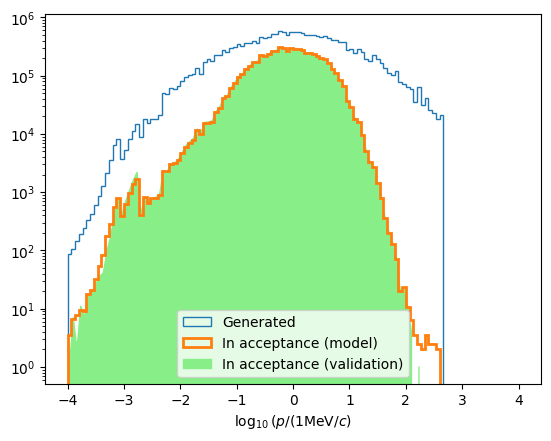

In [17]:
log_p = X_test[:,3]
bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p, bins=bins, weights=y_test.flatten())
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=preds.flatten())

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="Generated", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="In acceptance (model)", histtype='step', linewidth=2)
#plt.plot((bins[1:] + bins[:-1])/2, predicted_numerator, label="In acceptance (model)")
plt.fill_between(
    (bins[1:] + bins[:-1])/2, np.zeros(len(true_numerator)), true_numerator,
    label="In acceptance (validation)",
    color='#88ee88'
)
plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.yscale("log")
plt.legend()
plt.show()

In [18]:
import pickle

file_path = "/home/mabarbet/PythonFastSim/models/lb-trksim-train/acceptance/tX.pkl"

with open(file_path, "rb") as file:
    X_scaler = pickle.load(file)

In [19]:
import json

with open("./acceptance-validation/definitions.json") as json_file:
    definitions = json.load(json_file)

from pidgan.utils.preprocessing import invertColumnTransformer

for part in ["e", "mu", "h"]:
    query_index = definitions["features"].index(f"mc_is_{part}")
    query = X_test[:, query_index] == 1
    print(f"Shape for {part}:", X_test[query].shape, y_test[query].shape, preds[query].shape)
    
    X_query = invertColumnTransformer(X_scaler, X_test[query])

    np.savez_compressed(
        f"./exports/acceptance-results-{part}.npz",
        feat_vars=np.array(definitions["features"]),
        label_vars=np.array(definitions["labels"]),
        results=np.c_[X_query, y_test[query], preds[query]][:1_000_000],
    )

Shape for e: (4251195, 12) (4251195, 1) (4251195, 1)
Shape for mu: (330862, 12) (330862, 1) (330862, 1)
Shape for h: (15417943, 12) (15417943, 1) (15417943, 1)


## Export the model
Finally, we export the model to the same folder where the pretraining step was stored.

In [20]:
import os
default_output_model = "/home/mabarbet/PythonFastSim/models/lb-trksim-train/acceptance"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model
base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
model.export_model.save(output_model, save_format="tf")

INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/lb-trksim-train/acceptance/assets


INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/lb-trksim-train/acceptance/assets


## Conclusion

In this notebook we have:
 * loaded the training and validation data
 * defined a neural network model for the acceptance
 * trained the model on simulated data
 * performed a couple of sanity checks to ensure the training procedure did not fail
 * exported the model to disk
 
In the next notebook we will perform a more detaile validation, by splitting the sample in kinematic bins and comparing for each bin the distribution of particles in acceptance.